# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [30]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore, Phrases 
from gensim.models.phrases import Phraser 
from gensim.corpora import Dictionary
from IPython.display import display

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [31]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [32]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [33]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

          
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [34]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='category'>

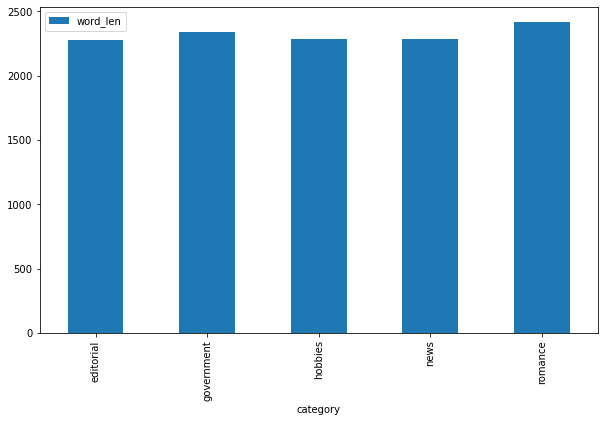

In [35]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [36]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [37]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors holds count of distinct words for each of the 166 documents<br> while tfidf_text_vectors holds the term frequency of each word that occurs in each of those documents. (This would be a ratio 0-1 representing use of that word within that document)

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [38]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [39]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [40]:
df['best_topic_nmf'] = W_text_matrix.argmax(axis=1)
df['best_topic_nmf'] = df['best_topic_nmf'].apply(lambda value: 'Topic-%s' % value)
df.sample(10)

,category,id,text,char_len,word_len,best_topic_nmf
112,romance,cp12,`` I had a rather small place of my own . A ni...,11297,2463,Topic-1
81,news,ca25,"Asilomar , March 26 Vast spraying programs con...",12615,2327,Topic-2
45,government,ch19,While there should be no general age limit or ...,12420,2194,Topic-0
86,news,ca30,A cookie with caramel filling and chocolate fr...,11658,2274,Topic-3
83,news,ca27,Santa Barbara -- `` The present recovery movem...,12554,2288,Topic-2
129,romance,cp29,"`` Good old A-Z '' , Cap said . `` You know , ...",12606,2417,Topic-1
94,news,ca38,The Masters golf tournament proved last Monday...,11358,2221,Topic-4
15,editorial,cb16,"`` A lousy job '' Chicago , Aug. 9 -- No doubt...",12290,2260,Topic-0
89,news,ca33,At last the White House is going to get some m...,12407,2284,Topic-3
96,news,ca40,Into Washington on President-elect John F. Ken...,12459,2340,Topic-3


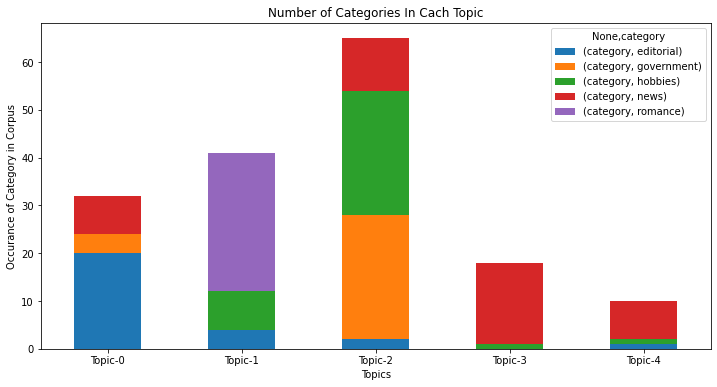

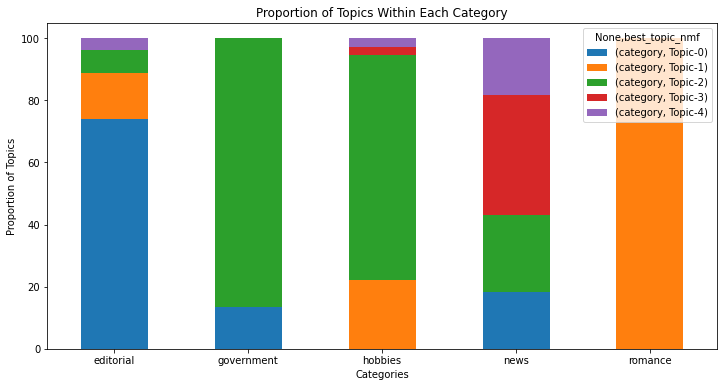

In [41]:
def create_charts_and_return_aggregate_df(df, column_name):
    # group by closest_topic aggregate by category count sort by category count number
    topic_with_category_legand = df.groupby([column_name, 'category']).agg({'category': 'count'})
    topic_with_category_legand.unstack().plot.bar(figsize=(12,6), stacked=True, rot=0)
    plt.title('Number of Categories In Cach Topic')
    plt.xlabel('Topics')
    plt.ylabel("Occurance of Category in Corpus")

    # proportion of topics based on category count
    category_with_topic_legand =  df.groupby(['category', column_name]).agg({'category': 'count'})
    perportion = category_with_topic_legand.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    perportion.unstack().plot.bar(figsize=(12,6), stacked=True, rot=0)
    plt.title('Proportion of Topics Within Each Category')
    plt.xlabel('Categories')
    plt.ylabel("Proportion of Topics")
    
    return topic_with_category_legand

summary_table_nmf = create_charts_and_return_aggregate_df(df, 'best_topic_nmf')   

In [42]:
# this is the same code as above. It is to show the same topics in one data frame
class CorpusModel:
    def __init__(self, components, features, no_top_words=5):
        self.topics = pd.DataFrame()
        
        for topic, words in enumerate(components):
            topic_title = 'Topic-%s' % topic
            largest = words.argsort()[::-1]
            top_word = [features[largest[n]] for n in range(1, no_top_words)]
            this_topic = pd.DataFrame(top_word, columns=[topic_title])
            self.topics = \
                pd.merge(self.topics, this_topic, left_index=True, right_index=True, how='right')
        
        self.show_topics()
        
    def show_topics(self):
        display(self.topics)

In [43]:
curpus_model = CorpusModel(nmf_text_model.components_, tfidf_text_vectorizer.get_feature_names())
summary_table_nmf

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4
0,president,didn,development,mr,league
1,kennedy,ll,tax,said,ball
2,united,thought,sales,miss,baseball
3,khrushchev,man,program,car,team


category
best_topic_nmf category            
Topic-0        editorial         20
               government         4
               news               8
Topic-1        editorial          4
               hobbies            8
               romance           29
Topic-2        editorial          2
               government        26
               hobbies           26
               news              11
Topic-3        hobbies            1
               news              17
Topic-4        editorial          1
               hobbies            1
               news               8

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: It can be observed that for example Topic-2 cotains words such as program, tax, development <br>
on the other, highest perportion of documents with government catory have Topic-2 <br>
Similarly, words like president, kennedy, united are seen manily in the editorial category <br>
and very few in the other categories.<br>
This is expected and there is a good alignment between the topics and categories.<br>


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


,category,id,text,char_len,word_len,best_topic_nmf,best_topic_svd
7,editorial,cb08,"Old , tired , trembling the woman came to the ...",11340,2395,Topic-1,Topic-0
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,Topic-2,Topic-0
61,news,ca05,East Providence should organize its civil defe...,12201,2244,Topic-0,Topic-0
22,editorial,cb23,Everywhere I went in Formosa I asked the same ...,12325,2357,Topic-0,Topic-0
63,news,ca07,Resentment welled up yesterday among Democrati...,12960,2270,Topic-0,Topic-0
99,news,ca43,Holders of toll-road bonds are finding improve...,12527,2291,Topic-2,Topic-0
55,government,ch29,"In recent months , much attention has been giv...",12843,2225,Topic-2,Topic-0
13,editorial,cb14,This is the period during the melancholy days ...,11875,2264,Topic-0,Topic-0
69,news,ca13,Rookie Ron Nischwitz continued his pinpoint pi...,11478,2241,Topic-4,Topic-4
158,hobbies,ce29,The controversy of the last few years over whe...,12903,2246,Topic-2,Topic-0


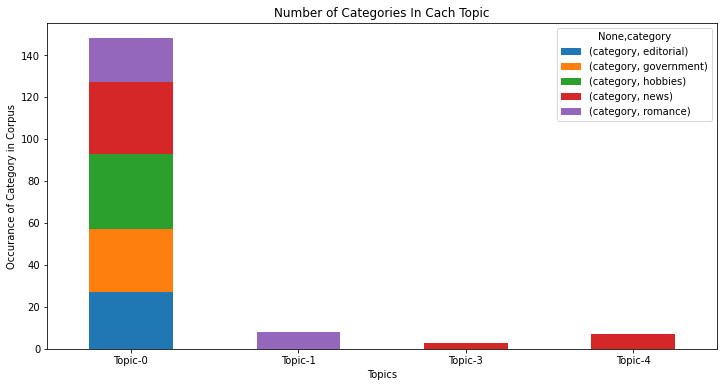

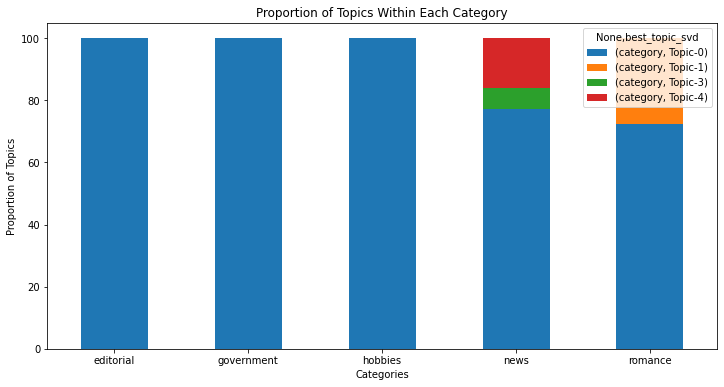

In [44]:
# Your code here

svd_text_model = TruncatedSVD(n_components = 5, random_state=110)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

df['best_topic_svd'] = W_svd_text_matrix.argmax(axis=1)
df['best_topic_svd'] = df['best_topic_svd'].apply(lambda value: 'Topic-%s' % value)
display(df.sample(10))

summary_table_svd = create_charts_and_return_aggregate_df(df, 'best_topic_svd')   

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: Very poorly, most categories are aligned with Topic-0 and very few documents are predicted to have other topics.

In [45]:
# call display_topics on your model
curpus_model.show_topics()
summary_table_svd

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4
0,president,didn,development,mr,league
1,kennedy,ll,tax,said,ball
2,united,thought,sales,miss,baseball
3,khrushchev,man,program,car,team


category
best_topic_svd category            
Topic-0        editorial         27
               government        30
               hobbies           36
               news              34
               romance           21
Topic-1        romance            8
Topic-3        news               3
Topic-4        news               7

Q: What is your interpretation of the display topics output? 

A: This model will not be a good fit to predict the topics since we know that <br>
words in topic-0 (president, kennedy, khrushchev, etc.) are not related to hobbies and romance.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [46]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

,category,id,text,char_len,word_len,best_topic_nmf,best_topic_svd,best_topic_lda
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,Topic-2,Topic-0,Topic-0
27,government,ch01,The Office of Business Economics ( OBE ) of th...,14404,2416,Topic-2,Topic-0,Topic-3
121,romance,cp21,Two letters had arrived for Miss Theresa Stubb...,12592,2520,Topic-1,Topic-0,Topic-4
109,romance,cp09,`` And I'll take you with me '' . The two of t...,10469,2187,Topic-1,Topic-0,Topic-4
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write...",11581,2298,Topic-4,Topic-0,Topic-0
67,news,ca11,"Miami , Fla. , March 17 -- The Orioles tonight...",11914,2259,Topic-4,Topic-4,Topic-0
128,romance,cp28,Martin felt it was incredible that the situati...,11559,2339,Topic-1,Topic-0,Topic-4
84,news,ca28,"Elburn , Ill. -- Farm machinery dealer Bob Hou...",12245,2220,Topic-2,Topic-0,Topic-2
159,hobbies,ce30,General How long has it been since you reviewe...,12981,2294,Topic-2,Topic-0,Topic-1
90,news,ca34,For crucial encounter One of the initial quest...,12524,2235,Topic-0,Topic-0,Topic-2


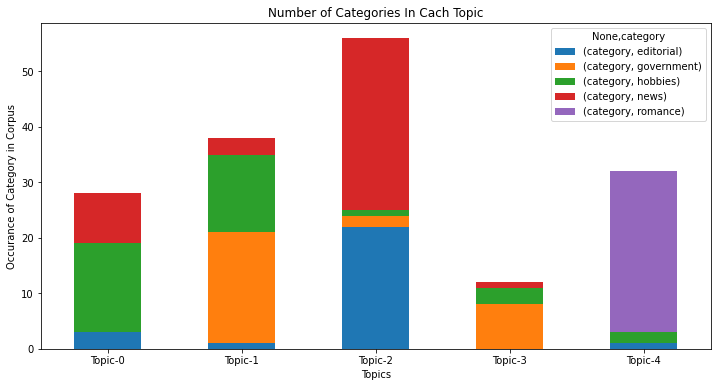

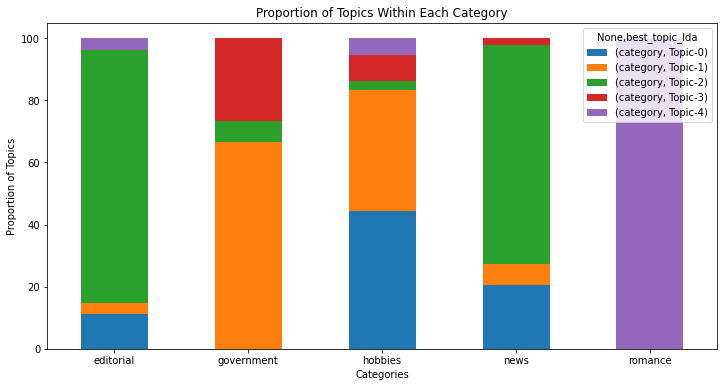

In [47]:
df['best_topic_lda'] = W_lda_text_matrix.argmax(axis=1)
df['best_topic_lda'] = df['best_topic_lda'].apply(lambda value: 'Topic-%s' % value)
display(df.sample(10))

summary_table_lda = create_charts_and_return_aggregate_df(df, 'best_topic_lda')  

In [48]:
# Call `display_topics` on your fitted model here
curpus_model_lda = CorpusModel(lda_text_model.components_, count_text_vectorizer.get_feature_names())

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4
0,right,development,mr,general,man
1,game,states,president,business,little
2,way,program,state,property,old
3,set,use,mrs,shall,good


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The words within each topic are totally different comapred to before. <br>
Also, The distinction in this new set of topics are not as useful to human eyes <br>
(i.e. the topics are not as intuitive as the previous version)

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: It makes sense to have words in Topic-1 (like development, states, program) in goverment documents.<br>
Same scenario can be observed with Topic-2 which has words like president in editorial documents.<br>
This is a good indicator, telling us that the LDA model works.

In [49]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/nima/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nima/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nima/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nima/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nima/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: 

In [50]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: This visualization is a powerful tool to see the overlaps between the classifications. <br>
Furthermore, the salient terms graph helps looking at the top words within each group how their occurance in other groups.<br>
It is amazing to see how group 1 (which contains baseball, coach, pitcher, team) are very far in terms of relavance compare to group 2<br> (which contains words like employee, inventory, academic).